# Transportation Optimization

In this notebook, we tackle a classic transportation optimization problem also known as a minimum-cost flow problem using a realistic supply chain dataset. The goal is simple in theory but powerful in practice: determine how much product to ship from each plant to each order while minimizing total transportation cost, subject to supply, demand, and routing constraints. This type of problem sits at the heart of logistics and operations research and appears in industries ranging from manufacturing and retail to energy.

#### Problem Overview

We model the supply chain as a network:

- Plants act as *supply nodes* with limited production or shipping capacity  
- Orders act as *demand nodes* that must be fully satisfied  
- Shipping lanes define which plant–order pairs are feasible  
- Costs are associated with shipping along each lane  

The optimization model decides how much to ship on each feasible lane, ensuring:

- Total shipments from a plant do not exceed its capacity  
- Every order’s demand is satisfied  
- Shipments only occur on valid routes  
- Total transportation cost is minimized  

This is a structured, interpretable optimization problem that lends itself well to linear programming and network flow techniques.

#### Dataset Source

The data used in this notebook comes from the Supply Chain Logistics Problem Dataset, originally published by researchers at Brunel University London on Figshare.

Source details:
- Title: Supply Chain Logistics Problem Dataset  
- Publisher: Brunel University London  
- Link: https://brunel.figshare.com/articles/dataset/Supply_Chain_Logistics_Problem_Dataset/7558679  

#### Dataset Structure

The dataset provides a complete snapshot of a multi-node supply chain, organized into several tables, including:

- OrderList – customer orders that must be fulfilled  
- Plants / Facilities – supply locations with capacity limits  
- Shipping Lanes / Routes – feasible connections between plants and orders  
- Cost & Attributes – transportation cost and lane-specific properties  

Together, these tables allow us to construct a realistic transportation network with real-world constraints.



In [185]:
import re
from pathlib import Path
from typing import Dict, Tuple, Optional, List
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy import sparse

In [186]:
rng = np.random.default_rng(42)
np.random.seed(42)

In [187]:
#!pip install cvxpy[glpk]
#!pip install ecos

In [188]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']


### Data description

- Plants (`plants`)
  - `plant_id`: unique identifier of a plant  
  - `supply_cap`: maximum supply capacity available at the plant  

- Orders (`orders`)
  - `order_id`: unique identifier of an order  
  - `demand`: required demand that must be satisfied  

- Lanes (`lanes`)
  - Each row represents a feasible shipping lane from a plant to an order  
  - `plant_id`, `order_id`: endpoints of the lane  
  - `unit_cost`: per-unit shipping cost on that lane  

After preprocessing:
- all plants and orders included in the model have at least one feasible lane
- total supply is sufficient to meet total demand

In [189]:
# -----------------------------
# Data Cleaning Utilities
# -----------------------------
def canon(s: str) -> str:
    """Canonical column name: lowercase, strip, replace non-alnum with underscore."""
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s


def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [canon(c) for c in df.columns]
    # Normalize common missing value tokens
    df = df.replace({"": np.nan, "NA": np.nan, "N/A": np.nan, "null": np.nan})
    return df


def load_excel_sheets(xlsx_path: Path) -> Dict[str, pd.DataFrame]:
    print(f"Loading workbook: {xlsx_path.resolve()}")
    xls = pd.ExcelFile(xlsx_path)
    sheets = {}
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        df = clean_df(df)
        sheets[canon(sheet_name)] = df
    print(f"Loaded {len(sheets)} sheets: {list(sheets.keys())}")
    return sheets

In [190]:
xlsx_path = Path("data/SupplyChainLogisticsProblems.xlsx")
sheets = load_excel_sheets(xlsx_path)

Loading workbook: C:\Users\salmank\Documents\convex_optimization\docs\convex\tutorials\data\SupplyChainLogisticsProblems.xlsx
Loaded 7 sheets: ['orderlist', 'freightrates', 'whcosts', 'whcapacities', 'productsperplant', 'vmicustomers', 'plantports']


In [191]:
# ----------------------------
# Demand measure
# ----------------------------
orders = sheets['orderlist'][['order_id', 'weight']]
orders.columns = ["order_id", "demand"]
orders = orders[orders["demand"] > 0].copy()
orders["order_id"] = orders["order_id"].astype(str)

# Retain top 1000 orders by demand
k = 1000
orders = (
    orders
    .sort_values("demand", ascending=False)
    .head(k)
    .reset_index(drop=True)
)

print(f"Orders retained: {len(orders)}")
orders.head()


# Total Demand capacity
total_demand = orders['demand'].sum()
print(f"Total orders: {len(orders)}")
print(f"Total demand capacity: {total_demand}")

orders.head()


Orders retained: 1000
Total orders: 1000
Total demand capacity: 129698.9734391597


,order_id,demand
0,1447281732.7,2338.405126
1,1447283095.7,1356.760000
2,1447156411.7,946.500000
3,1447167517.7,894.122186
4,1447389199.7,890.963690


In [192]:
# ----------------------------
# Plant capacities
# ----------------------------
plants = sheets['whcapacities']
plants.columns = ["plant_id", "supply_cap"]
plants["plant_id"] = plants["plant_id"].astype(str)
plants["supply_cap"] = pd.to_numeric(plants["supply_cap"], errors="coerce")
plants = plants.dropna(subset=["supply_cap"])
plants["supply_cap"] = plants["supply_cap"].astype(float) * 30

# Retain top 10 plants by supply capacity
plants = (
    plants
    .sort_values("supply_cap", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# Total Supply capacity
total_supply = plants["supply_cap"].sum()
print(f"Total plants: {len(plants)}")
print(f"Total supply capacity: {total_supply}")

plants.head()


Total plants: 10
Total supply capacity: 159720.0


,plant_id,supply_cap
0,PLANT01,32100.0
1,PLANT03,30390.0
2,PLANT04,16620.0
3,PLANT14,16470.0
4,PLANT13,14700.0


In [193]:
# Check Supply is enough to meet Demand
if total_supply < total_demand:
    raise ValueError(f"Total supply ({total_supply}) is less than total demand ({total_demand}). Problem is infeasible.")

In [194]:
# ----------------------------
# Build lane table (arc list) and unit costs
# ----------------------------
# NOTE: In this notebook we generate a mostly-dense plant×order lane set
#       with dummy unit costs, but randomly skip ~x% of connections
#       to mimic missing/infeasible shipping lanes in real data.

rng = np.random.default_rng(7)

plant_factor = {pid: 0.8 + 0.4 * rng.random() for pid in plants["plant_id"]}
plant_ids = plants["plant_id"].tolist()

skip_prob = 0.5  # probability of skipping a plant-order connection

lanes = []
for _, o in orders.iterrows():
    oid = o["order_id"]
    dem = float(o["demand"])
    order_jitter = 0.75 + 0.25 * rng.random()

    for pid in plant_ids:
        # randomly skip some connections
        if rng.random() < skip_prob:
            continue

        unit_cost = 1 * plant_factor[pid] * order_jitter
        lanes.append((pid, oid, unit_cost))

lanes = pd.DataFrame(lanes, columns=["plant_id", "order_id", "unit_cost"])

print(f"Total lanes (plant-order pairs): {len(lanes)}")
print(f"Total lanes (plant-order pairs) if we had full connectivity: {len(plants) * len(orders)}")

lanes.head()


Total lanes (plant-order pairs): 5048
Total lanes (plant-order pairs) if we had full connectivity: 10000


,plant_id,order_id,unit_cost
0,PLANT14,1447281732.7,0.734993
1,PLANT13,1447281732.7,0.759752
2,PLANT16,1447281732.7,0.949144
3,PLANT05,1447281732.7,0.662346
4,PLANT11,1447281732.7,0.931861


In [195]:
# ----------------------------
# Drop plants / orders with no lanes
# ----------------------------

print(
    f"Before cleanup: {len(plants)} plants, "
    f"{len(orders)} orders, "
    f"{len(lanes)} lanes"
)

plants_with_lane = set(lanes["plant_id"].unique())
orders_with_lane = set(lanes["order_id"].unique())

# Identify disconnected nodes
drop_plants = set(plants["plant_id"]) - plants_with_lane
drop_orders = set(orders["order_id"]) - orders_with_lane

if drop_plants:
    print(f"Dropping {len(drop_plants)} plant(s) with no lanes: {sorted(drop_plants)}")
    plants_with_lanes = plants[~plants["plant_id"].isin(drop_plants)].reset_index(drop=True)
else:
    plants_with_lanes = plants.copy()

if drop_orders:
    print(f"Dropping {len(drop_orders)} order(s) with no lanes: {sorted(drop_orders)}")
    orders_with_lanes = orders[~orders["order_id"].isin(drop_orders)].reset_index(drop=True)
else:
    orders_with_lanes = orders.copy()

# Keep lanes consistent with remaining plants and orders
lanes = lanes[
    lanes["plant_id"].isin(plants_with_lanes["plant_id"]) &
    lanes["order_id"].isin(orders_with_lanes["order_id"])
].reset_index(drop=True)

print(
    f"After cleanup: {len(plants_with_lanes)} plants, "
    f"{len(orders_with_lanes)} orders, "
    f"{len(lanes)} lanes"
)


Before cleanup: 10 plants, 1000 orders, 5048 lanes
Dropping 1 order(s) with no lanes: ['1447183486.7']
After cleanup: 10 plants, 999 orders, 5048 lanes


In [196]:
# ----------------------------
# Data integrity checks
# ----------------------------
# Ensure IDs are unique before we rely on index-based alignment later.

if not plants_with_lanes["plant_id"].is_unique:
    raise ValueError("plants.plant_id is not unique. Deduplicate or aggregate supplies first.")
if not orders_with_lanes["order_id"].is_unique:
    raise ValueError("orders.order_id is not unique. Deduplicate or aggregate demands first.")

In [197]:
# ----------------------------
# Clean / validate lanes
# ----------------------------
# 1) Drop lanes whose plant_id/order_id do not exist in the node tables.
# 2) If duplicate (plant_id, order_id) lanes exist, aggregate them (here: keep the minimum unit cost).

# Keep only lanes that connect to known plants/orders (avoid silent mismatches)
lanes = lanes.merge(plants[["plant_id"]], on="plant_id", how="inner")
lanes = lanes.merge(orders[["order_id"]], on="order_id", how="inner")

if lanes.empty:
    raise ValueError("No valid lanes after matching plant_id/order_id against plants/orders.")

lanes = (lanes.groupby(["plant_id", "order_id"], as_index=False).agg({'unit_cost': "min"}))

lanes.head()

,plant_id,order_id,unit_cost
0,PLANT01,1447133209.7,0.988836
1,PLANT01,1447133212.7,0.976652
2,PLANT01,1447133242.7,1.010273
3,PLANT01,1447137127.7,0.857992
4,PLANT01,1447138894.7,1.015662


In [198]:
# ----------------------------
# Define a *single source of truth* for indices
# ----------------------------
plant_ids = plants_with_lanes["plant_id"].to_numpy()
order_ids = orders_with_lanes["order_id"].to_numpy()

plant_to_i = {pid: i for i, pid in enumerate(plant_ids)}
order_to_j = {oid: j for j, oid in enumerate(order_ids)}

# Arc index = row index of lanes after reset
lanes = lanes.reset_index(drop=True)
nA = len(lanes)
nP = len(plant_ids)
nO = len(order_ids)

 # Build arc endpoint index arrays
arc_i = lanes["plant_id"].map(plant_to_i).to_numpy()
arc_j = lanes["order_id"].map(order_to_j).to_numpy()


arc_i = arc_i.astype(int)
arc_j = arc_j.astype(int)


In [199]:
# ----------------------------
# Build aligned vectors: cost c, supply, demand
# ----------------------------
# IMPORTANT: `c[a]` must correspond to the same arc as decision variable `x[a]`.
# Here, arc index a = row index of `lanes` after reset_index.

# Cost vector corresponds to arc order (lanes row order).
c = lanes['unit_cost'].to_numpy(dtype=float)

supply = plants.set_index("plant_id").loc[plant_ids, 'supply_cap'].to_numpy(dtype=float)
demand = orders.set_index("order_id").loc[order_ids, 'demand'].to_numpy(dtype=float)

# Ensure every order has at least one incoming lane
incoming_counts = np.bincount(arc_j, minlength=nO)
missing_orders = order_ids[incoming_counts == 0]
if len(missing_orders) > 0:
    raise ValueError(f"Orders with no incoming lanes: {missing_orders[:10]}{'...' if len(missing_orders) > 10 else ''}")

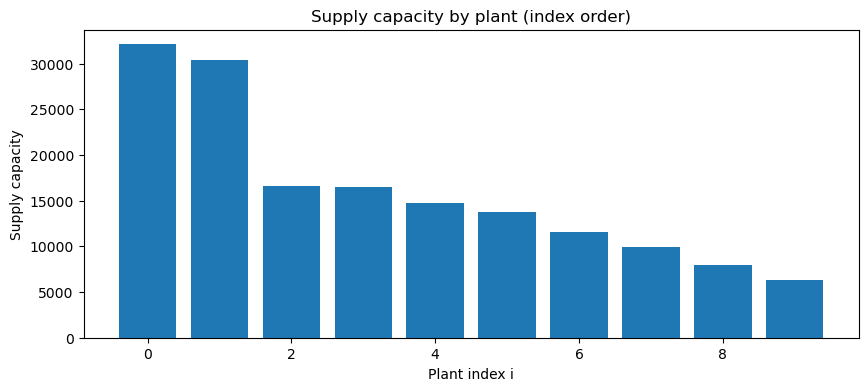

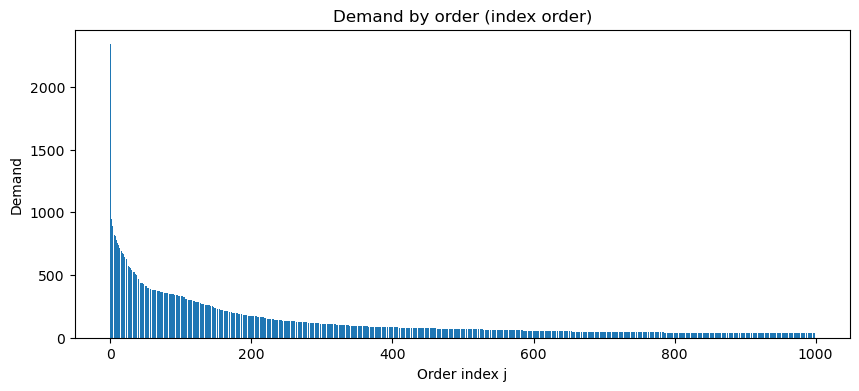

In [200]:
# ----------------------------
# Visuals: supply capacity by plant & demand by order
# ----------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(np.arange(len(supply)), supply)
ax.set_title("Supply capacity by plant (index order)")
ax.set_xlabel("Plant index i")
ax.set_ylabel("Supply capacity")
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(np.arange(len(demand)), demand)
ax.set_title("Demand by order (index order)")
ax.set_xlabel("Order index j")
ax.set_ylabel("Demand")
plt.show()


In [201]:
# ----------------------------
# Build sparse incidence matrices
# ----------------------------
# A_order[j, a] = 1 if arc a goes into order j
A_order = sparse.coo_matrix(
    (np.ones(nA), (arc_j, np.arange(nA))),
    shape=(nO, nA)
).tocsr()

# A_plant[i, a] = 1 if arc a goes out of plant i
A_plant = sparse.coo_matrix(
    (np.ones(nA), (arc_i, np.arange(nA))),
    shape=(nP, nA)
).tocsr()

A_order

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5048 stored elements and shape (999, 5048)>


### CVXPY Solver

Decision variables: Let  $x_{ij} \ge 0 $ denote the quantity shipped from plant \( i \) to order \( j \) on an existing lane.

Objective (minimize total shipping cost): $\min \sum_{(i,j)\in L} c_{ij}\,x_{ij}$

Constraints:
- Demand satisfaction (for each order \( j \)): $\sum_{i:(i,j)\in L} x_{ij} = d_j$
- Supply capacity (for each plant \( i \)): $\sum_{j:(i,j)\in L} x_{ij} \le s_i$


The problem is formulated and solved using CVXPY. With only continuous shipment variables, the model is a linear program (LP).

In [202]:
# ----------------------------
# Solve the LP in CVXPY
# ----------------------------
# Decision variable:
#   x[a] = shipment quantity on lane (arc) a
x = cp.Variable(nA, nonneg=True)

# Constraints:
#   - every order demand must be met exactly
#   - plant shipments cannot exceed supply capacity
constraints = [
    A_order @ x == demand,
    A_plant @ x <= supply
]

# Objective: min total shipping cost
objective = cp.Minimize(c @ x)
prob = cp.Problem(objective, constraints)

# Choose a good LP solver explicitly (fallback if unavailable)
preferred = "HIGHS"
installed = set(cp.installed_solvers())
solver = preferred if preferred in installed else ("GLPK" if "GLPK" in installed else None)
if solver is None:
    raise RuntimeError(f"No suitable LP solver found. Installed solvers: {sorted(installed)}")

_ = prob.solve(solver=solver, verbose=False)

print("Status:", prob.status)
print("Objective value:", prob.value)

if prob.status not in ("optimal", "optimal_inaccurate"):
    raise RuntimeError(f"Solve failed: status={prob.status}")

# Attach the solution back to the lane table (arc ordering!)
lanes_sol = lanes.copy()
lanes_sol["x"] = np.asarray(x.value).reshape(-1)

# ----------------------------
# Sanity checks (residuals)
# ----------------------------
order_resid = (A_order @ lanes_sol["x"].to_numpy()) - demand
plant_resid = (A_plant @ lanes_sol["x"].to_numpy()) - supply  # should be <= 0

diagnostics = {
    "status": prob.status,
    "objective": float(prob.value),
    "max_abs_order_residual": float(np.max(np.abs(order_resid))) if len(order_resid) else 0.0,
    "max_plant_violation": float(np.max(plant_resid)) if len(plant_resid) else 0.0,
    "solver_used": solver,
    "n_plants": int(nP),
    "n_orders": int(nO),
    "n_lanes": int(nA),
}

diagnostics


Status: optimal
Objective value: 113265.87945592123


{'status': 'optimal',
 'objective': 113265.87945592123,
 'max_abs_order_residual': 2.808064891723916e-11,
 'max_plant_violation': 2.546585164964199e-11,
 'solver_used': 'GLPK',
 'n_plants': 10,
 'n_orders': 999,
 'n_lanes': 5048}

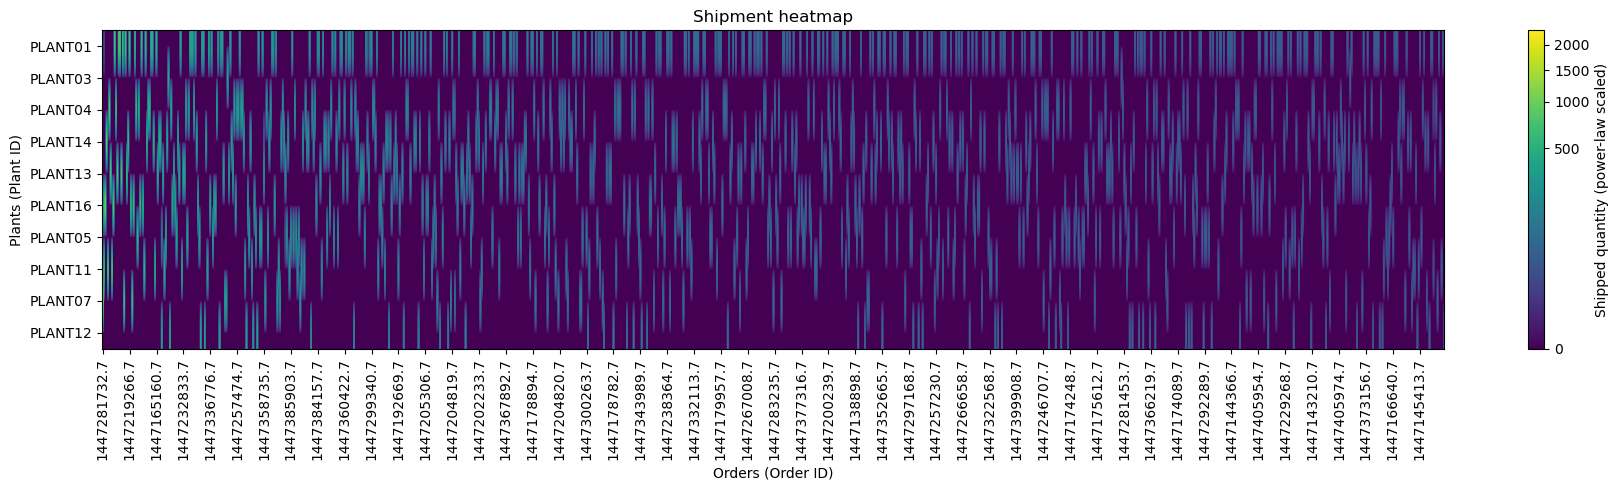

In [203]:
# ----------------------------
# Heatmap of shipped amounts (plants x orders)
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# lanes_sol must contain: plant_id, order_id, x
# plant_ids, order_ids are the index orders used elsewhere (strings)

# Build shipment matrix: rows=plants, cols=orders
ship = (lanes_sol
        .pivot_table(index="plant_id", columns="order_id", values="x", aggfunc="sum", fill_value=0.0)
       )

# Ensure full row/col order (so it matches your indexing)
ship = ship.reindex(index=plant_ids, columns=order_ids, fill_value=0.0)
order_totals = ship.sum(axis=0).sort_values(ascending=False)
ship = ship[order_totals.index]
plant_totals = ship.sum(axis=1).sort_values(ascending=False)
#ship = ship.loc[plant_totals.index]

X = ship.to_numpy()

from matplotlib.colors import PowerNorm

plt.figure(figsize=(18, 5))
im = plt.imshow(
    X,
    aspect="auto",
    cmap="viridis",
    norm=PowerNorm(gamma=0.3)
)

plt.title("Shipment heatmap")
plt.xlabel("Orders (Order ID)")
plt.ylabel("Plants (Plant ID)")

plt.yticks(np.arange(len(ship.index)), ship.index)

#step = max(1, len(ship.columns)//50)
step = 20
xt = np.arange(0, len(ship.columns), step)
plt.xticks(xt, ship.columns[xt], rotation=90)

plt.colorbar(im, label="Shipped quantity (power-law scaled)")
plt.tight_layout()
plt.show()
